In [199]:
import os, sys
import numpy
import subprocess
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
plt.rcParams.update({'font.size': 10})

In [200]:
getbinary = lambda x: format(x, 'b').zfill(8)

In [284]:
def read_loc_flags(name, pos, mod):
    
    if mod == 'loc':
        col = 'LOC_FLGS'
    if mod == 'time':
        col = 'TIMEFLGS'
        
    # Reading the location flags array
    hdul = fits.open(name)
    flags = hdul[1].data['LOC_FLGS']
    flat = list(np.concatenate(flags).flat)
    flatarr = np.array(flat, dtype=int)
    hdul.close()
    
    # Reading the flag at the corresponding position
    flg = [int(getbinary(flatarr[j])[-pos]) for j in range(0, len(flatarr))]
    
    return np.array(flg, dtype=int)

In [250]:
def read_time_status_flags(name, pos):
    
    # Reading the location flags array
    hdul = fits.open(name)
    flags = hdul[3].data['STATUS_FLAGS']
    flat = list(np.concatenate(flags).flat)
    flatarr = np.array(flat, dtype=int)
    hdul.close()
    
    # Reading the flag at the corresponding position
    flg = [int(getbinary(flatarr[j])[-pos]) for j in range(0, len(flatarr))]
    
    return np.array(flg, dtype=int)

# Reading and exploring raw files

In [228]:
# Setting path and filenames
path = '/home/mia/Documents/work_UA/Data/test/white_dwarf/'
file = 'M10703150011attagfraw.fit'

In [105]:
# Reading the file
hdul = fits.open(path+file)
hdul.info()

Filename: /home/mia/Documents/work_UA/Data/test/white_dwarf/M10703150011attagfraw.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     366   ()      
  1  EVENTS        1 BinTableHDU     40   565775R x 4C   [1E, 1I, 1I, 1B]   
  2  GTI           1 BinTableHDU     22   1R x 2C   [1D, 1D]   


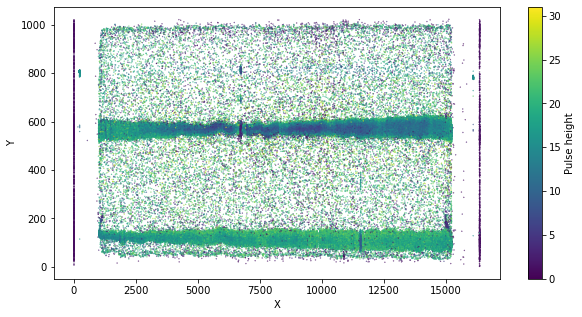

In [106]:
# Plotting all photon events on the XY plane
dat = hdul[1].data

fig, ax = plt.subplots(1,1, figsize=(10,5))
plot = ax.scatter(dat['X'], dat['Y'], s=0.1, c=dat['PHA'])
cbar = plt.colorbar(plot)
cbar.set_label('Pulse height')
ax.set_ylabel('Y')
ax.set_xlabel('X')
plt.show()

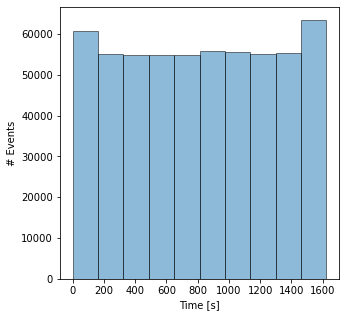

In [107]:
# Plotting histogram of photon events as a function of time

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.hist(dat['Time'], edgecolor='black', alpha=0.5)
ax.set_xlabel('Time [s]')
ax.set_ylabel('# Events')
plt.show()

In [52]:
hdul.close()

# Generating intermediate files

The routine transforms the raw data into an intermediate data file (IDF): copy X, Y, arrival time, puls height of each photon event; initialization of weight. Photon events outside of the detector active region are flagged. Two more extensions: good time intervals (directly copies from raw file), and timeline table containing 16 arrays with status flags, spacecraft position, detector high-voltage, countrate parameters, listed once per second. 

In [229]:
# Running the FUSE initialization routine
os.system('rm test_IDF_ttag.fit')
process_str = 'cf_ttag_init '+path+file+' test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

   cf_ttag_init-1.42: This is CalFUSE v3.2.3
   cf_timeline-1.41: No housekeeping file: filling timeline with header info.
2022 Jul  8 12:14:06 cf_ttag_init-1.42: Finished processing


CompletedProcess(args='cf_ttag_init /home/mia/Documents/work_UA/Data/test/white_dwarf/M10703150011attagfraw.fit test_IDF_ttag.fit', returncode=0)

In [230]:
# Reading the file
hdul = fits.open('test_IDF_ttag.fit')
hdul.info()

Filename: test_IDF_ttag.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     366   ()      
  1  TTAG DATA     1 BinTableHDU     59   1R x 14C   [565775E, 565775I, 565775I, 565775B, 565775E, 565775I, 565775I, 565775I, 565775I, 565775B, 565775B, 565775B, 565775E, 565775E]   
  2  GTI           1 BinTableHDU     21   1R x 2C   [1D, 1D]   
  3  TIMELINE      1 BinTableHDU     73   1R x 16C   [1624E, 1624B, 1624I, 1624I, 1624I, 1624I, 1624I, 1624I, 1624I, 1624I, 1624I, 1624I, 1624I, 1624I, 1624I, 1624I]   


In [55]:
hdul[1].columns

ColDefs(
    name = 'TIME'; format = '565775E'; unit = 'SECONDS'
    name = 'XRAW'; format = '565775I'; unit = 'PIXELS'
    name = 'YRAW'; format = '565775I'; unit = 'PIXELS'
    name = 'PHA'; format = '565775B'; unit = 'UNITLESS'
    name = 'WEIGHT'; format = '565775E'; unit = 'UNITLESS'
    name = 'XFARF'; format = '565775I'; unit = 'PIXELS'; bscale = 0.25; bzero = 8192.0
    name = 'YFARF'; format = '565775I'; unit = 'PIXELS'; bscale = 0.1; bzero = 0.0
    name = 'X'; format = '565775I'; unit = 'PIXELS'; bscale = 0.25; bzero = 8192.0
    name = 'Y'; format = '565775I'; unit = 'PIXELS'; bscale = 0.1; bzero = 0.0
    name = 'CHANNEL'; format = '565775B'; unit = 'UNITLESS'
    name = 'TIMEFLGS'; format = '565775B'; unit = 'UNITLESS'
    name = 'LOC_FLGS'; format = '565775B'; unit = 'UNITLESS'
    name = 'LAMBDA'; format = '565775E'; unit = 'ANGSTROMS'
    name = 'ERGCM2'; format = '565775E'; unit = 'ERG CM^-2'
)

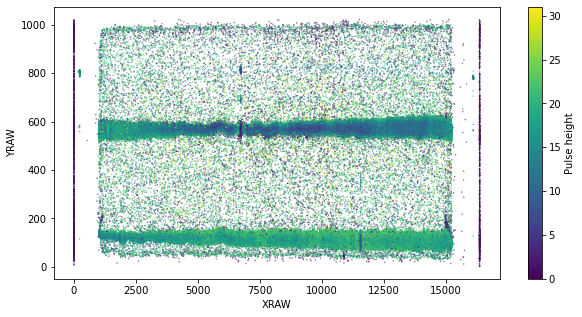

In [56]:
# Plotting all photon events on the XY plane
dat = hdul[1].data

fig, ax = plt.subplots(1,1, figsize=(10,5))
plot = ax.scatter(dat['XRAW'], dat['YRAW'], s=0.1, c=dat['PHA'])
cbar = plt.colorbar(plot)
cbar.set_label('Pulse height')
ax.set_ylabel('YRAW')
ax.set_xlabel('XRAW')
plt.show()

# The event distribution on the detector looks the same as in the raw 
# data file, as expected. 

In [57]:
print(np.amax(dat['LOC_FLGS']))

1


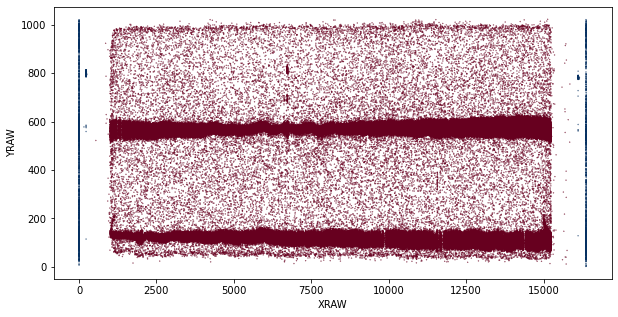

In [58]:
# Plotting all photon events on the XY plane
dat = hdul[1].data

fig, ax = plt.subplots(1,1, figsize=(10,5))
plot = ax.scatter(dat['XRAW'], dat['YRAW'], s=0.1, c=dat['LOC_FLGS'], 
                 cmap='RdBu')
ax.set_ylabel('YRAW')
ax.set_xlabel('XRAW')
plt.show()

# The blue events are flagged as they occurr outside of the detector 
# active region. 

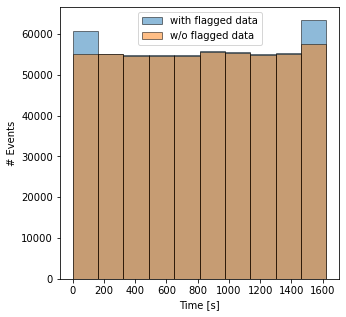

In [59]:
# Plotting histogram of photon events as a function of time
# one histogram including all data
# and another one excluding the data outside the activeregion

dat = hdul[1].data

fig, ax = plt.subplots(1,1, figsize=(5,5))

time = np.array(np.concatenate(dat['Time']).flat)
loc_flgs = np.array(np.concatenate(dat['LOC_FLGS']).flat, dtype=bool)
loc_flgs = np.invert(loc_flgs)

ax.hist(time, edgecolor='black', alpha=0.5, label='with flagged data')
ax.hist(time[loc_flgs>0], edgecolor='black', alpha=0.5, label='w/o flagged data')
ax.set_xlabel('Time [s]')
ax.set_ylabel('# Events')
ax.legend()
plt.show()

# The photon events outside the active region mostly occurred at the 
# very beginning and and of the exposure.

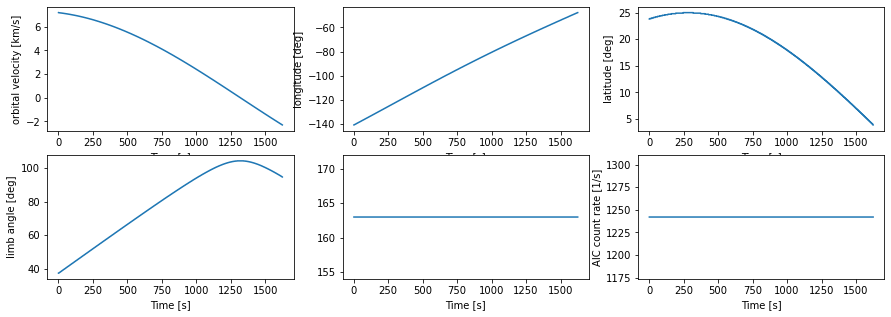

In [60]:
# plotting a few parameters from the third extennsion

# reading from file
dat = hdul[3].data
time = np.array(np.concatenate(dat['TIME']).flat)
orbital_vel = np.array(np.concatenate(dat['ORBITAL_VEL']).flat)
long = np.array(np.concatenate(dat['LONGITUDE']).flat)
lat = np.array(np.concatenate(dat['LATITUDE']).flat)
limb = np.array(np.concatenate(dat['LIMB_ANGLE']).flat)
volt = np.array(np.concatenate(dat['HIGH_VOLTAGE']).flat)
aic = np.array(np.concatenate(dat['AIC_CNT_RATE']).flat)

# generating the plot
fig, ax = plt.subplots(2, 3, figsize=(15,5))
ax[0,0].plot(time, orbital_vel)
ax[0,0].set_ylabel('orbital velocity [km/s]')
ax[0,1].plot(time, long)
ax[0,1].set_ylabel('longitude [deg]')
ax[0,2].plot(time, lat)
ax[0,2].set_ylabel('latitude [deg]')
ax[1,0].plot(time, limb)
ax[1,0].set_ylabel('limb angle [deg]')
ax[1,1].plot(time, volt)
ax[1,1].set_label('high voltage')
ax[1,2].plot(time, aic)
ax[1,2].set_ylabel('AIC count rate [1/s]')
[axx.set_xlabel('Time [s]') for axx in ax.flat]
plt.show()

In [16]:
hdul.close()

# Conversion to FARF

This module removes detector artifacts (dead time and positional inaccuracies) and consists of the subroutines cf_check_digitizer, cf_electronics_dead_time, cf_ids_dead_time, cf_fifo_dead_time, cf_apply_deadtime

## Digitizer keyword

Compares 16 values stored in file header keywords reporting on detector settings with values in calibration file 'DIGI_CAL'. When significant differences are present, warnings are written into the header and trailer files and the header keyword EXP_STAT is in that case set to -2. 

In [231]:
# Running the FUSE initialization routine
process_str = 'cf_convert_to_farf -eiftrsgpa test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

2022 Jul  8 12:14:19 cf_convert_to_farf-1.22: Finished processing


CompletedProcess(args='cf_convert_to_farf -eiftrsgpa test_IDF_ttag.fit', returncode=0)

In [232]:
# Checking header keyword EXP_STAT after running the subroutine
hdul = fits.open('test_IDF_ttag.fit')
print(hdul[0].header['EXP_STAT'])
hdul.close()

# No discrepancies occurred, as expected. 

0


## Correct for detector dead time

### Correct for electronics, IDS and FIFO dead time at once

In [64]:
# Retrieve weights before applying correction

hdul = fits.open('test_IDF_ttag.fit')
weight = (hdul[1].data['WEIGHT']).copy()
time = (hdul[1].data['TIME']).copy()
hdul.close()

In [233]:
# Running the FUSE subroutine
process_str = 'cf_convert_to_farf -ctrsgpa test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

2022 Jul  8 12:14:25 cf_convert_to_farf-1.22: Finished processing


CompletedProcess(args='cf_convert_to_farf -ctrsgpa test_IDF_ttag.fit', returncode=0)

In [66]:
# Reading weights after the correction

hdul = fits.open('test_IDF_ttag.fit')
weight_f = (hdul[1].data['WEIGHT']).copy()
time_f = (hdul[1].data['TIME']).copy()
hdul.close()

### Comparison of all dead time corrections

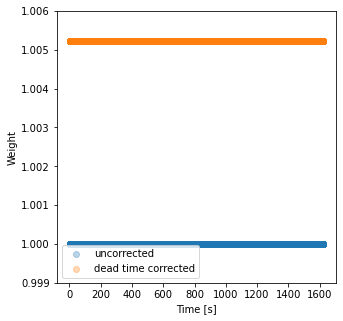

In [67]:
# Plotting the weights after each step of correction
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(time, weight, alpha=0.3, label='uncorrected')
ax.scatter(time_f, weight_f, alpha=0.3, label='dead time corrected')
ax.set_ylim(0.9990,1.006)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Weight')
plt.legend()
plt.show()

# The total correction is of about 0.06%.

## Correct for detector distortions

### Temperature dependent changes in detector coordinates

Temperature changes can cause drifts in detector electronics affecting the coordinate system. Drifts (mostly along X coordinate) are tracked by injecting stim pulses at the upper right and left corners of detectors, and are used to compute a scaling factor to move them to their reference points, which are then applied to X and Y coordinates. 

In [7]:
# Testing X and Y coordinates before correction
hdul = fits.open('test_IDF_ttag.fit')
Xraw = (hdul[1].data['XRAW']).copy() 
Yraw = (hdul[1].data['YRAW']).copy() 
Xold = (hdul[1].data['XFARF']).copy() 
Yold = (hdul[1].data['YFARF']).copy() 
hdul.close()

In [234]:
process_str = 'cf_convert_to_farf -ceifrsgpa test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

2022 Jul  8 12:14:28 cf_convert_to_farf-1.22: Finished processing


CompletedProcess(args='cf_convert_to_farf -ceifrsgpa test_IDF_ttag.fit', returncode=0)

In [70]:
# Testing X and Y coordinates after correction

hdul = fits.open('test_IDF_ttag.fit')
X = (hdul[1].data['XFARF']).copy() 
Y = (hdul[1].data['YFARF']).copy() 
hdul.close()

print('X: ', X/Xold)
print('Y: ', Y/Yold)
# X and Y are corrections are on the order of 0.1 promille.

X:  [[1.0015095  1.00044978 1.00194747 ... 1.00076394 1.00091303 1.00219024]]
Y:  [[0.99721739 0.99796178 0.99724613 ... 0.99698682 0.99710669 0.99834197]]


/tmp/ipykernel_84677/3088191257.py:8: RuntimeWarning: invalid value encountered in true_divide
  print('X: ', X/Xold)


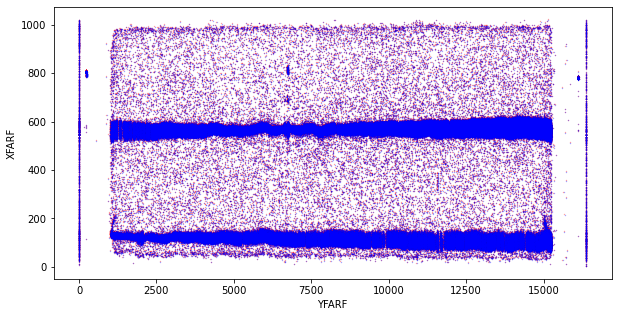

In [71]:
# Plotting all photon events before and after correction

fig, ax = plt.subplots(1,1, figsize=(10,5))
plot = ax.scatter(Xold, Yold, s=0.1, color='red', alpha=0.5)
plot = ax.scatter(X, Y, s=0.1, color='blue', alpha=0.5)
ax.set_ylabel('XFARF')
ax.set_xlabel('YFARF')
plt.show()


In [9]:

hdul = fits.open('test_IDF_ttag.fit')
print(hdul[1].data['XRAW'])
print(hdul[1].data['XFARF'])
hdul.close()

[[ 5631 16119  4493 ... 10472  8762  3995]]
[[ 5639.5  16126.25  4501.75 ... 10480.    8770.    4003.75]]


### Correct y scale distortions

In [73]:
# Checking coordinates before correction
hdul = fits.open('test_IDF_ttag.fit')
Xold = (hdul[1].data['XFARF']).copy() 
Yold = (hdul[1].data['YFARF']).copy() 
hdul.close()

In [235]:
process_str = 'cf_convert_to_farf -ceiftsgpa test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

2022 Jul  8 12:14:32 cf_convert_to_farf-1.22: Finished processing


CompletedProcess(args='cf_convert_to_farf -ceiftsgpa test_IDF_ttag.fit', returncode=0)

In [75]:
# Testing X and Y coordinates after correction

hdul = fits.open('test_IDF_ttag.fit')
X = (hdul[1].data['XFARF']).copy() 
Y = (hdul[1].data['YFARF']).copy() 
hdul.close()

print('X: ', Xold/X)
print('Y: ', Yold/Y)
# X and Y are corrections are on the order of about 1 promille.

X:  [[1.0015095  1.00044978 1.00194747 ... 1.00076394 1.00091303 1.00219024]]
Y:  [[1.00087275 0.99796178 1.00086371 ... 0.99981114 1.00036284 1.00542684]]


/tmp/ipykernel_84677/1800689522.py:8: RuntimeWarning: invalid value encountered in true_divide
  print('X: ', Xold/X)


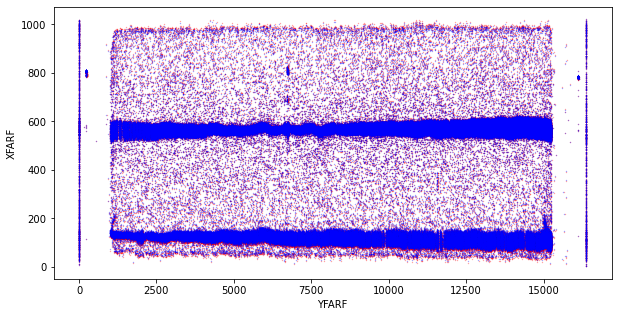

In [78]:
# Plotting all photon events before and after correction

fig, ax = plt.subplots(1,1, figsize=(10,5))
plot = ax.scatter(Xold, Yold, s=0.1, color='red', alpha=0.5)
plot = ax.scatter(X, Y, s=0.1, color='blue', alpha=0.5)
ax.set_ylabel('XFARF')
ax.set_xlabel('YFARF')
plt.show()
hdul.close()

In [11]:

hdul = fits.open('test_IDF_ttag.fit')
print(hdul[1].data['XRAW'])
print(hdul[1].data['XFARF'])

[[ 5631 16119  4493 ... 10472  8762  3995]]
[[ 5631. 16119.  4493. ... 10472.  8762.  3995.]]


### Correcting time dependent changes in detector coordinates

In [80]:
# Checking coordinates before correction
hdul = fits.open('test_IDF_ttag.fit')
Xold = (hdul[1].data['XFARF']).copy() 
Yold = (hdul[1].data['YFARF']).copy() 
hdul.close()

In [236]:
process_str = 'cf_convert_to_farf -ceiftrgpa test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

2022 Jul  8 12:14:38 cf_convert_to_farf-1.22: Finished processing


CompletedProcess(args='cf_convert_to_farf -ceiftrgpa test_IDF_ttag.fit', returncode=0)

In [82]:
# Testing X and Y coordinates after correction

hdul = fits.open('test_IDF_ttag.fit')
X = (hdul[1].data['XFARF']).copy() 
Y = (hdul[1].data['YFARF']).copy() 
hdul.close()

print('X: ', X/Xold)
print('Y: ', Y/Yold)
# X and Y are corrections are on the order of about 1 promille.

X:  [[1. 1. 1. ... 1. 1. 1.]]
Y:  [[1.00488741 1.         1.00483676 ... 1.00377715 1.00435414 1.00918389]]


/tmp/ipykernel_84677/1635220535.py:8: RuntimeWarning: invalid value encountered in true_divide
  print('X: ', X/Xold)


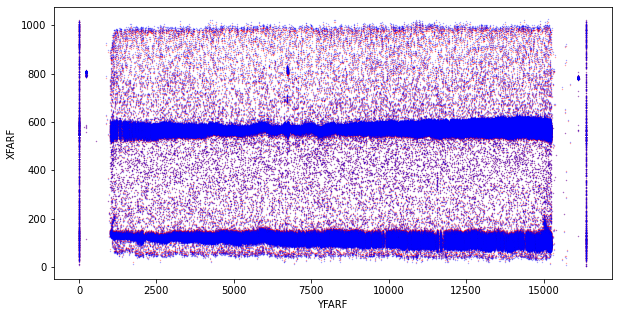

In [83]:
# Plotting all photon events before and after correction

fig, ax = plt.subplots(1,1, figsize=(10,5))
plot = ax.scatter(Xold, Yold, s=0.1, color='red', alpha=0.5)
plot = ax.scatter(X, Y, s=0.1, color='blue', alpha=0.5)
ax.set_ylabel('XFARF')
ax.set_xlabel('YFARF')
plt.show()

In [13]:
hdul = fits.open('test_IDF_ttag.fit')
print(hdul[1].data['XRAW'])
print(hdul[1].data['XFARF'])
hdul.close()

[[ 5631 16119  4493 ... 10472  8762  3995]]
[[ 5631. 16119.  4493. ... 10472.  8762.  3995.]]


### Correcting geometric distortion

In [79]:
# Checking coordinates before correction
hdul = fits.open('test_IDF_ttag.fit')
Xold = (hdul[1].data['XFARF']).copy() 
Yold = (hdul[1].data['YFARF']).copy() 
hdul.close()

In [237]:
process_str = 'cf_convert_to_farf -ceiftrspa test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

2022 Jul  8 12:14:42 cf_convert_to_farf-1.22: Finished processing


CompletedProcess(args='cf_convert_to_farf -ceiftrspa test_IDF_ttag.fit', returncode=0)

In [81]:
# Testing X and Y coordinates after correction

hdul = fits.open('test_IDF_ttag.fit')
X = (hdul[1].data['XFARF']).copy() 
Y = (hdul[1].data['YFARF']).copy() 
hdul.close()

print('X: ', X/Xold)
print('Y: ', Y/Yold)
# X and Y are corrections are on the order of about 1 promille.

X:  [[1.00048837 1.         1.00016693 ... 0.99914057 0.99971468 1.        ]]
Y:  [[0.97655029 1.         0.97833935 ... 0.96839135 0.9738078  1.01158221]]


/tmp/ipykernel_81559/1635220535.py:8: RuntimeWarning: invalid value encountered in true_divide
  print('X: ', X/Xold)


/home/mia/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


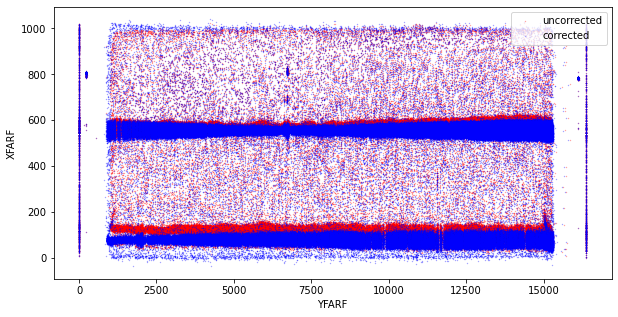

In [83]:

# Plotting all photon events before and after correction
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot = ax.scatter(Xold, Yold, s=0.1, color='red', alpha=0.5, label='uncorrected')
plot = ax.scatter(X, Y, s=0.1, color='blue', alpha=0.5, label='corrected')
ax.set_ylabel('XFARF')
ax.set_xlabel('YFARF')
plt.legend(loc='upper right')
plt.show()

In [15]:
hdul = fits.open('test_IDF_ttag.fit')
print(hdul[1].data['XRAW'])
print(hdul[1].data['XFARF'])

[[ 5631 16119  4493 ... 10472  8762  3995]]
[[ 5633.75 16119.    4493.75 ... 10463.    8759.5   3995.  ]]


### Correcting pulse height variations along x dimension

In [84]:
# Checking coordinates before correction
hdul = fits.open('test_IDF_ttag.fit')
Xold = (hdul[1].data['XFARF']).copy() 
Yold = (hdul[1].data['YFARF']).copy() 
hdul.close()

In [238]:
process_str = 'cf_convert_to_farf -ceiftrsga test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

2022 Jul  8 12:14:45 cf_convert_to_farf-1.22: Finished processing


CompletedProcess(args='cf_convert_to_farf -ceiftrsga test_IDF_ttag.fit', returncode=0)

In [86]:
# Testing X and Y coordinates after correction

hdul = fits.open('test_IDF_ttag.fit')
X = (hdul[1].data['XFARF']).copy() 
Y = (hdul[1].data['YFARF']).copy() 
hdul.close()

print('X: ', X/Xold)
print('Y: ', Y/Yold)
# X and Y are corrections are on the order of about 1 promille.

X:  [[0.9971156  1.         0.99833102 ... 1.00083628 1.00034249 0.99192741]]
Y:  [[1.0227677  1.         1.02091021 ... 1.03166893 1.02578371 0.98650583]]


/tmp/ipykernel_81559/1635220535.py:8: RuntimeWarning: invalid value encountered in true_divide
  print('X: ', X/Xold)
/tmp/ipykernel_81559/1635220535.py:9: RuntimeWarning: divide by zero encountered in true_divide
  print('Y: ', Y/Yold)


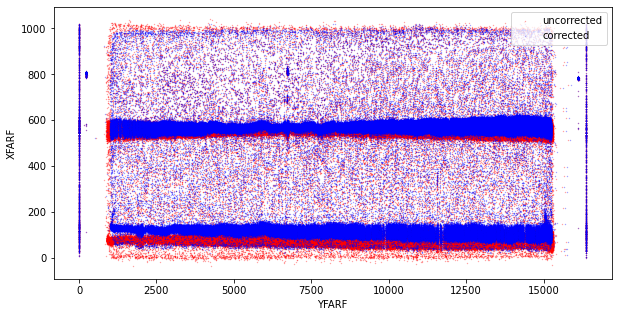

In [87]:
# Plotting all photon events before and after correction
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot = ax.scatter(Xold, Yold, s=0.1, color='red', alpha=0.5, label='uncorrected')
plot = ax.scatter(X, Y, s=0.1, color='blue', alpha=0.5, label='corrected')
ax.set_ylabel('XFARF')
ax.set_xlabel('YFARF')
plt.legend(loc='upper right')
plt.show()

In [17]:
hdul = fits.open('test_IDF_ttag.fit')
print(hdul[1].data['XRAW'])
print(hdul[1].data['XFARF'])

[[ 5631 16119  4493 ... 10472  8762  3995]]
[[ 5617.5  16119.    4486.25 ... 10471.75  8762.5   3962.75]]


### Checking for detector active region

In [239]:
# Checking coordinates before correction
# why ???
print(np.sum(read_loc_flags('test_IDF_ttag.fit', 1)))

13523


In [240]:
process_str = 'cf_convert_to_farf -ceiftrsgp test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

2022 Jul  8 12:14:56 cf_convert_to_farf-1.22: Finished processing


CompletedProcess(args='cf_convert_to_farf -ceiftrsgp test_IDF_ttag.fit', returncode=0)

In [220]:
# Checking coordinates before correction
print(np.sum(read_loc_flags('test_IDF_ttag.fit', 1)))

# 13000 events have been flagged

13546


No handles with labels found to put in legend.


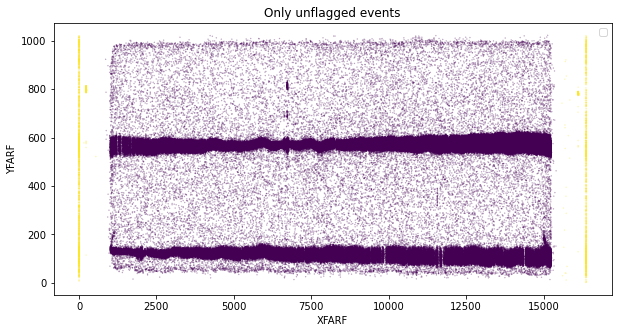

In [223]:
# Plotting all photon events before and after correction
dat = fits.open('test_IDF_ttag.fit')

fig, ax = plt.subplots(1,1, figsize=(10,5))

ar_flags = read_loc_flags('test_IDF_ttag.fit', 1)
Xtrue = (dat[1].data['XFARF'])
Ytrue = (dat[1].data['YFARF'])
plot = ax.scatter(Xtrue,Ytrue, s=0.1, 
                  c=ar_flags, alpha=0.5)
ax.set_ylabel('YFARF')
ax.set_xlabel('XFARF')
plt.legend(loc='upper right')
plt.title('Only unflagged events')
plt.show()
hdul.close()

### Comparison before / after FARF corrections

In [241]:
# Running the FUSE initialization routine
os.system('rm test_IDF_ttag.fit')
process_str = 'cf_ttag_init '+path+file+' test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

   cf_ttag_init-1.42: This is CalFUSE v3.2.3
   cf_timeline-1.41: No housekeeping file: filling timeline with header info.
2022 Jul  8 12:15:23 cf_ttag_init-1.42: Finished processing


CompletedProcess(args='cf_ttag_init /home/mia/Documents/work_UA/Data/test/white_dwarf/M10703150011attagfraw.fit test_IDF_ttag.fit', returncode=0)

In [242]:
process_str = 'cf_convert_to_farf test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

2022 Jul  8 12:15:25 cf_convert_to_farf-1.22: Finished processing


CompletedProcess(args='cf_convert_to_farf test_IDF_ttag.fit', returncode=0)

In [24]:
hdul = fits.open('test_IDF_ttag.fit')
print(hdul[1].data['XRAW'])
print(hdul[1].data['XFARF'])

[[ 5631 16119  4493 ... 10472  8762  3995]]
[[ 5629.   16126.25  4495.5  ... 10470.75  8768.25  3972.  ]]


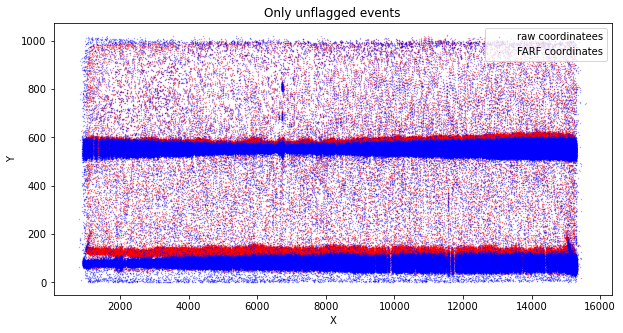

In [26]:
# Plotting all photon events before and after correction
dat = fits.open('test_IDF_ttag.fit')

Xtrue = (dat[1].data['XFARF'])[dat[1].data['LOC_FLGS']==0]
Ytrue = (dat[1].data['YFARF'])[dat[1].data['LOC_FLGS']==0]
Xraw  = (dat[1].data['XRAW'])[dat[1].data['LOC_FLGS']==0]
Yraw  = (dat[1].data['YRAW'])[dat[1].data['LOC_FLGS']==0]

fig, ax = plt.subplots(1,1, figsize=(10,5))

plot = ax.scatter(Xraw,Yraw, s=0.1, 
                  color='red', alpha=0.5, label='raw coordinatees')
plot = ax.scatter(Xtrue,Ytrue, s=0.1, 
                  color='blue', alpha=0.5, label='FARF coordinates')
ax.set_ylabel('Y')
ax.set_xlabel('X')
plt.legend(loc='upper right')
plt.show()
dat.close()

# Screen photons

## Airglow screening

In [243]:
process_str = 'cf_screen_photons -lstbjufimdp test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

2022 Jul  8 12:15:35 cf_screen_photons-1.29: Finished processing


CompletedProcess(args='cf_screen_photons -lstbjufimdp test_IDF_ttag.fit', returncode=0)

No handles with labels found to put in legend.


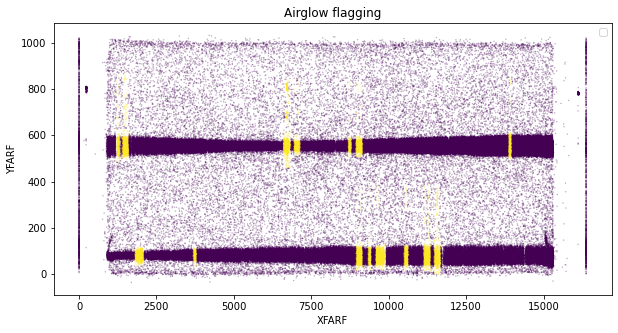

In [244]:
# Plotting all photon events before and after correction
dat = fits.open('test_IDF_ttag.fit')

fig, ax = plt.subplots(1,1, figsize=(10,5))

airglow_flags = read_loc_flags('test_IDF_ttag.fit', 2)
Xtrue = (dat[1].data['XFARF'])
Ytrue = (dat[1].data['YFARF'])
plot = ax.scatter(Xtrue,Ytrue, s=0.1, 
                  c=airglow_flags, alpha=0.5)
ax.set_ylabel('YFARF')
ax.set_xlabel('XFARF')
plt.legend(loc='upper right')
plt.title('Airglow flagging')
plt.show()
dat.close()

## Limb angle screening

In [254]:
process_str = 'cf_screen_photons -astbjufimdp test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

2022 Jul  8 12:25:40 cf_screen_photons-1.29: Finished processing


CompletedProcess(args='cf_screen_photons -astbjufimdp test_IDF_ttag.fit', returncode=0)

In [256]:
limb_flags = read_time_status_flags('test_IDF_ttag.fit', 2)
np.sum(limb_flags)

0

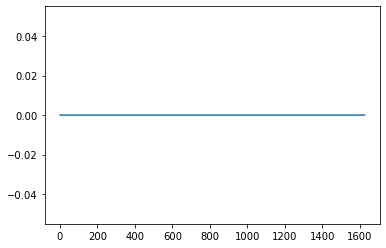

In [260]:
hdul = fits.open('test_IDF_ttag.fit')
time = hdul[3].data['TIME']
time = list(np.concatenate(time).flat)
plt.plot(time, limb_flags)
hdul.close()

## SAA screening

In [263]:
process_str = 'cf_screen_photons -altbjufimdp test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

2022 Jul  8 12:31:04 cf_screen_photons-1.29: Finished processing


CompletedProcess(args='cf_screen_photons -altbjufimdp test_IDF_ttag.fit', returncode=0)

In [265]:
saa_flags = read_time_status_flags('test_IDF_ttag.fit', 3)
np.sum(saa_flags)

42

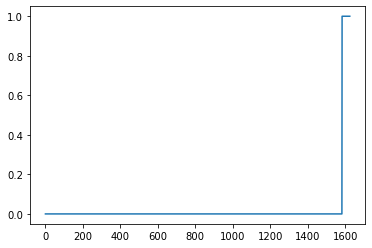

In [266]:
hdul = fits.open('test_IDF_ttag.fit')
time = hdul[3].data['TIME']
time = list(np.concatenate(time).flat)
plt.plot(time, saa_flags)
hdul.close()

## High voltage screening

2022 Jul  8 12:33:53 cf_screen_photons-1.29: Finished processing
0


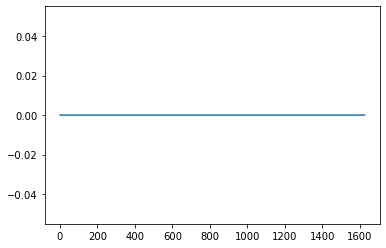

In [267]:
process_str = 'cf_screen_photons -alsbjufimdp test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

hv_flags = read_time_status_flags('test_IDF_ttag.fit', 4)
print(np.sum(hv_flags))

hdul = fits.open('test_IDF_ttag.fit')
time = list(np.concatenate(hdul[3].data['TIME']).flat)
plt.plot(time, hv_flags)
hdul.close()

## Detector bursts

2022 Jul  8 12:34:52 cf_screen_photons-1.29: Finished processing
30


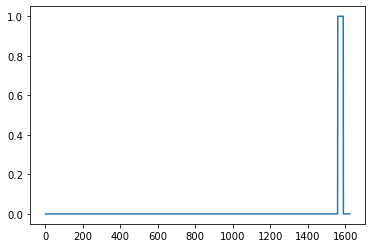

In [268]:
process_str = 'cf_screen_photons -alstjufimdp test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

burst_flags = read_time_status_flags('test_IDF_ttag.fit', 5)
print(np.sum(burst_flags))

hdul = fits.open('test_IDF_ttag.fit')
time = list(np.concatenate(hdul[3].data['TIME']).flat)
plt.plot(time, burst_flags)
hdul.close()

## Jitter screening

   cf_screen_jitter-1.13: Jitter file not found.  No jitter correction.
2022 Jul  8 12:36:04 cf_screen_photons-1.29: Finished processing
0


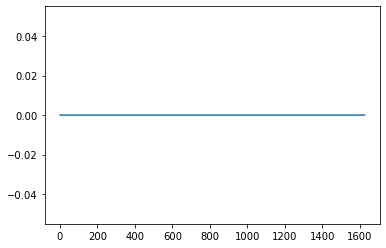

In [269]:
process_str = 'cf_screen_photons -alstbufimdp test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

jitter_flags = read_time_status_flags('test_IDF_ttag.fit', 7)
print(np.sum(jitter_flags))

hdul = fits.open('test_IDF_ttag.fit')
time = list(np.concatenate(hdul[3].data['TIME']).flat)
plt.plot(time, jitter_flags)
hdul.close()

In [270]:
# Jitter file not found??? 

## bad pixel screening

2022 Jul  8 12:48:26 cf_screen_bad_pixels-1.1: WARNING - Exiting.
	cf_screen_bad_pixels has already been run on this file.


2022 Jul  8 12:48:26 cf_screen_photons-1.29: Finished processing
Number of flagged events: 625


No handles with labels found to put in legend.


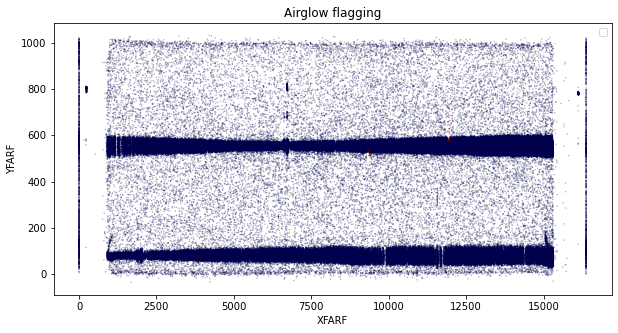

In [274]:
process_str = 'cf_screen_photons -alstbjufimp test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

bp_flags = read_loc_flags('test_IDF_ttag.fit', 6)
print('Number of flagged events:', np.sum(bp_flags))


# Plotting all photon events before and after correction
dat = fits.open('test_IDF_ttag.fit')

fig, ax = plt.subplots(1,1, figsize=(10,5))

airglow_flags = read_loc_flags('test_IDF_ttag.fit', 2)
Xtrue = (dat[1].data['XFARF'])
Ytrue = (dat[1].data['YFARF'])
plot = ax.scatter(Xtrue,Ytrue, s=0.1, 
                  c=bp_flags, alpha=0.5, cmap='seismic')
ax.set_ylabel('YFARF')
ax.set_xlabel('XFARF')
plt.legend(loc='upper right')
plt.title('Airglow flagging')
plt.show()
dat.close()

## Screening pulse height

2022 Jul  8 12:50:16 cf_screen_photons-1.29: Finished processing
Number of flagged events: 625


No handles with labels found to put in legend.


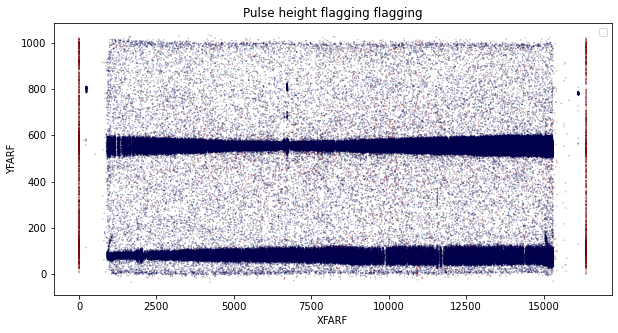

In [275]:
process_str = 'cf_screen_photons -alstbjufimd test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

ph_flags = read_loc_flags('test_IDF_ttag.fit', 5)
print('Number of flagged events:', np.sum(bp_flags))


# Plotting all photon events before and after correction
dat = fits.open('test_IDF_ttag.fit')

fig, ax = plt.subplots(1,1, figsize=(10,5))

Xtrue = (dat[1].data['XFARF'])
Ytrue = (dat[1].data['YFARF'])
plot = ax.scatter(Xtrue,Ytrue, s=0.1, 
                  c=ph_flags, alpha=0.5, cmap='seismic')
ax.set_ylabel('YFARF')
ax.set_xlabel('XFARF')
plt.legend(loc='upper right')
plt.title('Pulse height flagging flagging')
plt.show()
dat.close()

## Checking all flags together

In [287]:

# Running the FUSE initialization routine
os.system('rm test_IDF_ttag.fit')

process_str = 'cf_ttag_init '+path+file+' test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

process_str = 'cf_convert_to_farf test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

process_str = 'cf_screen_photons test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

   cf_ttag_init-1.42: This is CalFUSE v3.2.3
   cf_timeline-1.41: No housekeeping file: filling timeline with header info.
2022 Jul  8 13:06:12 cf_ttag_init-1.42: Finished processing
2022 Jul  8 13:06:12 cf_convert_to_farf-1.22: Finished processing
   cf_screen_jitter-1.13: Jitter file not found.  No jitter correction.
2022 Jul  8 13:06:13 cf_screen_photons-1.29: Finished processing


CompletedProcess(args='cf_screen_photons test_IDF_ttag.fit', returncode=0)

No handles with labels found to put in legend.


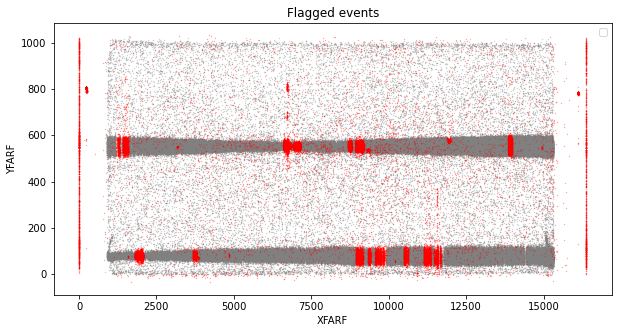

In [308]:
# Plotting all photon events before and after correction
dat = fits.open('test_IDF_ttag.fit')
fig, ax = plt.subplots(1,1, figsize=(10,5))
Xtrue = np.array(np.concatenate(dat[1].data['XFARF']).flat)
Ytrue = np.array(np.concatenate(dat[1].data['YFARF']).flat)

loc_flags = np.zeros(len(Xtrue), dtype=int)
time_flags = np.zeros(len(Xtrue), dtype=int)


for i in range(0, 9):
    loc_flags += read_loc_flags('test_IDF_ttag.fit', i, 'loc')
    time_flags += read_loc_flags('test_IDF_ttag.fit', i, 'time')

flags = loc_flags+time_flags
plot = ax.scatter(Xtrue[flags==0],Ytrue[flags==0], s=0.1, 
                  color='gray', alpha=0.5)
plot = ax.scatter(Xtrue[flags>0],Ytrue[flags>0], s=0.1, 
                  color='red', alpha=0.5)
ax.set_ylabel('YFARF')
ax.set_xlabel('XFARF')
plt.legend(loc='upper right')
plt.title('Flagged events')
plt.show()
dat.close()


In [307]:
os.system('cf_remove_motions --help')

Usage:
  cf_remove_motions [-hagfmj] [-p pad] [-v level] idf_file

Options:
  -h:  this help message
  -v:  verbose level (default is 1; 0 is silent)
  -a:  use airglow lines to determine spectral centroid
  -p:  aperture padding in pixels (default is 10)
  -g:  no grating motion correction
  -f:  no fpa position correction
  -m:  no mirror motion correction
  -j:  no satellite jitter correction


cf_remove_motions: invalid option -- '-'


0

In [57]:
# Spectral extraction

In [59]:
process_str = 'cf_extract_spectra --help'
subprocess.run(process_str, shell=True)

Usage:
  cf_extract_spectra [-hsof] [-n bpm_filename] [-r rootname] [-v level] idf_file

Options:
  -h:  this help message
  -n:  extract night-only spectrum using given bad-pixel map
  -o:  disable optimal extraction
  -f:  force optimal extraction
  -r:  override the default rootname
  -s:  do not perform screening on time flags
  -v:  verbosity level (=1; 0 is silent)


cf_extract_spectra: invalid option -- '-'


CompletedProcess(args='cf_extract_spectra --help', returncode=0)

In [71]:
process_str = 'cf_extract_spectra test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

   cf_standard_or_optimal_extraction-1.7: SRC_TYPE = EE.  No optimal extraction.
   cf_scale_bkgd-1.25: Calculating a full background model.
No bad pixel (BPM_CAL) file found.  Assuming no potholes.
No bad pixel (BPM_CAL) file found.  Assuming no potholes.
2022 Jul  6 13:21:02 cf_extract_spectra-1.32: Finished processing


CompletedProcess(args='cf_extract_spectra test_IDF_ttag.fit', returncode=0)

In [72]:
%ls -lrt

total 4392
-rw-rw-r-- 1 mia mia  941760 Jun 18 10:53 outfile_IDF.fit
-rw-rw-r-- 1 mia mia     594 Jun 20 08:09 README.md
-rw-rw-r-- 1 mia mia       0 Jul  6 13:16 P13401010092b_bursts.dat
-rw-rw-r-- 1 mia mia 1399243 Jul  6 13:19 pipeline_exploration.ipynb
-rw-rw-r-- 1 mia mia 1673280 Jul  6 13:20 test_IDF_ttag.fit
-rw-rw-r-- 1 mia mia  236160 Jul  6 13:21 P13401010092blif4ttagfcal.fit
-rw-rw-r-- 1 mia mia  236160 Jul  6 13:21 P13401010092bsic4ttagfcal.fit


In [84]:
file = fits.open('P13401010092blif4ttagfcal.fit')
len(file[1].data['WAVE'])

7693

In [92]:
np.shape(file[1].data['QUALITY'])

(7693,)

In [86]:
file[1].columns

ColDefs(
    name = 'WAVE'; format = '1E'; unit = 'ANGSTROMS'
    name = 'FLUX'; format = '1E'; unit = 'ERG CM^-2 S^-1 ANG^-1'
    name = 'ERROR'; format = '1E'; unit = 'ERG CM^-2 S^-1 ANG^-1'
    name = 'COUNTS'; format = '1J'; unit = 'COUNTS'
    name = 'WEIGHTS'; format = '1E'; unit = 'COUNTS'
    name = 'BKGD'; format = '1E'; unit = 'COUNTS'
    name = 'QUALITY'; format = '1I'; unit = 'UNITLESS'
)

In [93]:
subprocess.run('cf_extract_spectra --h', shell=True)

#Usage:
#  cf_screen_photons [-halstbjufimdp] [-v level] idf_file

cf_extract_spectra: invalid option -- '-'


CompletedProcess(args='cf_extract_spectra --h', returncode=0)

Usage:
  cf_extract_spectra [-hsof] [-n bpm_filename] [-r rootname] [-v level] idf_file

Options:
  -h:  this help message
  -n:  extract night-only spectrum using given bad-pixel map
  -o:  disable optimal extraction
  -f:  force optimal extraction
  -r:  override the default rootname
  -s:  do not perform screening on time flags
  -v:  verbosity level (=1; 0 is silent)


In [95]:
file = fits.open('test_IDF_ttag.fit')
file[1].columns

ColDefs(
    name = 'TIME'; format = '47300E'; unit = 'SECONDS'
    name = 'XRAW'; format = '47300I'; unit = 'PIXELS'
    name = 'YRAW'; format = '47300I'; unit = 'PIXELS'
    name = 'PHA'; format = '47300B'; unit = 'UNITLESS'
    name = 'WEIGHT'; format = '47300E'; unit = 'UNITLESS'
    name = 'XFARF'; format = '47300I'; unit = 'PIXELS'; bscale = 0.25; bzero = 8192.0
    name = 'YFARF'; format = '47300I'; unit = 'PIXELS'; bscale = 0.1; bzero = 0.0
    name = 'X'; format = '47300I'; unit = 'PIXELS'; bscale = 0.25; bzero = 8192.0
    name = 'Y'; format = '47300I'; unit = 'PIXELS'; bscale = 0.1; bzero = 0.0
    name = 'CHANNEL'; format = '47300B'; unit = 'UNITLESS'
    name = 'TIMEFLGS'; format = '47300B'; unit = 'UNITLESS'
    name = 'LOC_FLGS'; format = '47300B'; unit = 'UNITLESS'
    name = 'LAMBDA'; format = '47300E'; unit = 'ANGSTROMS'
    name = 'ERGCM2'; format = '47300E'; unit = 'ERG CM^-2'
)